In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Approximate solutions to MILPs

One important application of first order methods for non-differentiable objectives is to solve dual problems associated to discrete/mixed-integer optimization programs, i.e., problems entailing binary or integer variables.

### Step 1

Consider the following optimization program (MILP):
$$
\begin{array}{ll}
\min\limits_x     & -\frac{1}{2} x_1 - x_2 + x_3\\
\mathrm{s.t.}    & \frac{1}{2} x_1 + \frac{1}{2} x_2 + x_3 \geq 1\\
& x_1 + x_2 \leq 1\\
& 0 \leq x_1,x_2,x_3 \leq 1\\
& x_1 \in \left\{0,1\right\}.
\end{array}
$$

One can verify that the (unique) optimizer for this problem is $x^\star = [0, 1, 1]$. We generally work with problems for which we find it hard to compute an exact optimizer, and wish to explore possibilities of computing approximate solutions instead.

Note that without the first two constraints, the problem is trivial: it reduces to a linear optimization over a unit box, so an optimal value for $x_i$ would be 0 if its corresponding coefficient in the objective is positive, and 1 otherwise. 

### Step 2

The general idea of duality is to take advantage of this type of situation: when a problem becomes significantly simpler if some constraints were to be discarded, we can take advantage of this fact to produce approximate solutions. This is what we mean when we say we are "exploiting the strucutre of the problem". What we are doing here is deciding on a set of complicating constraints which we dualize in the objective. With this procedure we can derive a corresponding dual problem, which we can then solve using the first-order methods in this package. 

**Remark**: generally, we want to relax as few constraints as possible, as the quality of the approximation depends on it.

**Remark**: the discussion in this notebook pertains situations in which we have "complicating constraints". The same framework can be applied to situations in which we have "complicating variables", as we do for the examples concerning decomposition of some problems arising in computer vision and stochastic optimization.

With our choice of constraints to be dualized, we get the following corresponding dual function $d(\lambda)$:

$$
\begin{array}{lcll}
d(\lambda) & = & \min\limits_x & -\frac{1}{2} x_1 - x_2 + x_3 + \lambda_1 (1 - \frac{1}{2} x_1 - \frac{1}{2} x_2 - x_3) + \lambda_2(x_1+x_2 -1)\\
&& \mathrm{s.t.} & 0 \leq x_1,x_2,x_3 \leq 1\\
&&& x_1 \in \left\{0,1\right\}. \\
\end{array}
$$

Note that while our primal problem is an optimization model where $x$ is the optimization variable, in the above dual function the variable is $\lambda$, while $x$ is "hidden" in the so-called inner optimization model.

The important advantage we have recovered from dualizing constraints is that evaluating the dual function $d(\lambda)$ for a given $\lambda$ is trivial: the *inner* optimization problem simply sets to 0 variables that, for given $\lambda$, have a positive objective; otherwise 1 (as noted before). When plotted, the dual function $d(\lambda)$ looks like this:
![dual function](img/ex_2.png)
It turns out that for discrete primal problems, the dual function $d(\lambda)$ is non-smooth, and we would like to optimize (maximize) it according to the dual problem:

$$
\begin{array}{ll}
\max\limits_\lambda & d(\lambda) \\
\mathrm{s.t.} & \lambda \in \Lambda
\end{array}
$$

where $\Lambda = \mathbb{R}_+^2$ (so-called positive orthant). 

**Remark:** the structure of $\Lambda$ depends on the constraints we are dualizing. Roughly speaking, if the $i$-th constraint dualized is an inequality "$\leq$", the corresponding $i$-th entry in $\lambda_k$ has to be positive, i.e., $\lambda_k[i] \geq 0$; if the constraint is an equality, $\lambda_k[i]$ is free. There might be regions where the dual function is unbounded from below, which we also typically want to avoid by integrating the corresponding constraints in $\Lambda$; this is beyond the scope of this tutorial.

Notice that, in contrast to the example discussed [here](./AnalyticalExample.ipynb), where the entire function was known analytically a priori, in this case we do not have an explicit analytical expression for $d(\lambda)$ but we can query its first order oracle, i.e., know the gradient and the function value of $d(\lambda_k)$ for a given $\lambda_k \in \Lambda$.

This problem belongs to the battery of test cases for this package, so we can simply import it and pass it to our solvers.

In [2]:
from nsopy.tests.analytical_oracles import AnalyticalExampleInnerProblem

inner_problem = AnalyticalExampleInnerProblem()

We can choose a solution method and go through the iterations

In [3]:
from nsopy import SGMDoubleSimpleAveraging as DSA
from nsopy import SGMTripleAveraging as TA
from nsopy import SubgradientMethod as SG
from nsopy import UniversalPGM as UPGM
from nsopy import UniversalDGM as UDGM
from nsopy import UniversalFGM as UFGM

from nsopy.method_loggers import GenericDualMethodLogger

dual_method = UPGM(inner_problem.oracle, inner_problem.projection_function, epsilon=0.01)
method_logger = GenericDualMethodLogger(dual_method)

for iteration in range(60):
    dual_method.dual_step()

... and plot the resulting method's trajectory:

<IPython.core.display.Javascript object>


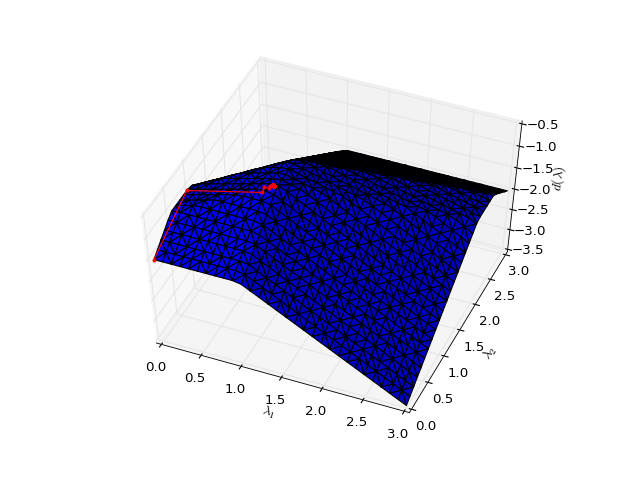

In [4]:
box = np.linspace(0, 3, 30)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(np.array([lmd_1 for lmd_1 in box for lmd_2 in box]),
                np.array([lmd_2 for lmd_1 in box for lmd_2 in box]),
                np.array([inner_problem.oracle(np.array([lmd_1, lmd_2]))[1] for lmd_1 in box for lmd_2 in box]))
ax.set_xlabel('$\lambda_1$')
ax.set_ylabel('$\lambda_2$')
ax.set_zlabel('$d(\lambda)$')

plt.plot([lmd[0] for lmd in method_logger.lambda_k_iterates],
         [lmd[1] for lmd in method_logger.lambda_k_iterates],
         [d_lmd for d_lmd in method_logger.d_k_iterates], 'r.-')

**Note 1**: you can try all the different methods. 

**Note 2**: the instantiation of the methods implemented requires the `dimension` argument to be defined. This can be avoided if the `projection_function(lambda_k)` method can be called with $\lambda_k=0$, and returns a gradient of appropriate dimension.

### Step 3

We can now inspect the $\lambda_k$ produced by our solution methods at iteration $k$; we are particularly interested in the last iterate:

In [5]:
lambda_k = method_logger.lambda_k_iterates[-1]
print(lambda_k)

[ 1.00852273  1.00852273]


which we can use to evaluate $d(\lambda_k)$. An approximate solution to our initial primal problem is given by the solution of the inner problem at $\lambda_k$, which we denote by $x(\lambda_k)$:

In [6]:
x_k, d_k, diff_d_k = inner_problem.oracle(lambda_k)
print(x_k)

[ 0.  1.  1.]


In this particular case we actually recovered the optimizer of the problem, which, as noted above, is indeed $x^\star = [0,1,1]$. This is a lucky coincidence though. We can namely inspect the inner solutions recovered at earlier steps; these are also stored in the logger:

In [7]:
method_logger.x_k_iterates[-10:]

[array([ 0.,  1.,  0.]),
 array([ 0.,  1.,  1.]),
 array([ 0.,  1.,  0.]),
 array([ 0.,  1.,  1.]),
 array([ 0.,  1.,  0.]),
 array([ 0.,  1.,  1.]),
 array([ 0.,  1.,  0.]),
 array([ 0.,  1.,  1.]),
 array([ 0.,  1.,  0.]),
 array([ 0.,  1.,  1.])]

It looks like $x_1$ and $x_2$ are stuck at $0$ and $1$ respectively, while $x_3$ oscillates between $0$ and $1$. Choosing $x_3 = 1$ leads to the optimizer, while $x_3 = 0$ resolves in an infeasible primal point. 

This is the nature of this type of approximation, which in the literature is called *Lagrangian Relaxation*: while we go through our dual iterates $\lambda_k$, we inspect the inner solutions recovered; we generally do not have any guarantees on whether these inner solutions are optimal or even feasible, but in practice they often turn out to be very good approximations. There are special problem structures for which we can provide some feasibility and performance guarantees, but this is beyond the scope of this brief introduction.

These dual methods are the basis of a class of solutions architectures used to solve large, complex integer optimization models. They can be combined with heuristics which can rectify infeasibile solutions into feasible ones. They are also the main machinery behind solution methods like *column generation* and *Benders decomposition*. Dual methods can also be used to produce strong lower bounds for primal optimization problems: we have in fact that $d(\lambda_k) \leq p^\star$ for all $\lambda_k \in \Lambda$, where $p^\star$ is the optimizer of the primal problem.